In [1]:
import dask.dataframe as dd

In [2]:
import geopandas as gpd 


In [3]:
df=dd.read_csv(r'personas_censo2024\personas_censo2024.csv', sep=';', encoding='latin-1', assume_missing=True)

In [4]:
df.head(5)

,id_vivienda,id_hogar,id_persona,region,provincia,comuna,comuna_bajo_umbral,area,tipo_operativo,sexo,...,p45_medio_transporte,p46a_tot_hijs_nac,p46b_hijas_nac,p46c_hijos_nac,p47a_tot_hijs_sobrev,p47b_hijas_sobrev,p47c_hijos_sobrev,p48_anio_nac_uh,p48_mes_nac_uh,div_genero
0,1.0,1.0,1.0,5.0,58.0,5802.0,2.0,1.0,2.0,2.0,...,NaN,3.0,2.0,1.0,3.0,2.0,1.0,1978.0,7.0,2.0
1,1.0,1.0,2.0,5.0,58.0,5802.0,2.0,1.0,2.0,1.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,1.0,1.0,3.0,5.0,58.0,5802.0,2.0,1.0,2.0,2.0,...,3.0,1.0,1.0,0.0,1.0,1.0,0.0,2015.0,9.0,2.0
3,1.0,1.0,4.0,5.0,58.0,5802.0,2.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,1.0,1.0,4.0,43.0,4303.0,2.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-66.0


In [5]:
# Mapeo para p45_medio_transporte
transporte_mapping = {
    1: 'Auto particular',
    2: 'Transporte público',
    3: 'Caminando',
    4: 'Bicicleta/Scooter',
    5: 'Motocicleta',
    6: 'Caballo/lancha/bote',
    7: 'Otro',
    -99: 'No respuesta'
}

# Aplicar el mapeo con meta para evitar warnings
df['p45_medio_transporte_desc'] = df['p45_medio_transporte'].map(transporte_mapping, meta=('p45_medio_transporte_desc', 'object'))

# Verificar el mapeo
df['p45_medio_transporte_desc'].value_counts().compute()

p45_medio_transporte_desc
Caminando               677171
Motocicleta              95687
Auto particular        2341926
Bicicleta/Scooter       254215
Otro                    465580
No respuesta              1266
Caballo/lancha/bote       6348
Transporte público     2793070
Name: count, dtype: int64

In [6]:
comunas_esp=dd.read_csv('comunas.csv')

In [7]:
# Crear diccionario desde el CSV
comunas_dict = dict(zip(comunas_esp['Código específico'].compute(), comunas_esp['Territorio específico'].compute()))

# Aplicar el mapeo a la columna comuna
df['comuna_map'] = df['comuna'].map(comunas_dict, meta=('comuna_map', 'object'))

In [8]:
df['lugar_trabajo'] = df['p44_lug_trab_esp'].map(comunas_dict, meta=('lugar_trabajo', 'object'))

In [10]:
import geopandas as gpd
carto= gpd.read_file('GDB_SIET-Chile_04Dic2025\GDB_SIET-Chile_04Dic2025\SIET-Chile_04Dic2025_Publicacion.gdb')


<>:2: SyntaxWarning: invalid escape sequence '\G'
<>:2: SyntaxWarning: invalid escape sequence '\G'
C:\Users\naoca\AppData\Local\Temp\ipykernel_22668\2366035151.py:2: SyntaxWarning: invalid escape sequence '\G'
  carto= gpd.read_file('GDB_SIET-Chile_04Dic2025\GDB_SIET-Chile_04Dic2025\SIET-Chile_04Dic2025_Publicacion.gdb')
c:\Users\naoca\.conda\envs\borelian-viz\Lib\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'SIET-Chile_04Dic2025_Publicacion.gdb': 'SIET_CULTURAL' (default), 'SIET_ECONOMICA', 'SIET_AMBIENTAL', 'SIET_SOCIAL'. Specify layer parameter to avoid this warning.
  result = read_func(
c:\Users\naoca\.conda\envs\borelian-viz\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts.  The processing may be really slow.  You can skip the processing by setting METHOD=SKIP.
  return ogr_read(


In [11]:
def analizar_caso(df, nombre_caso, regiones=None, comunas_lista=None):
    """
    Analiza un caso específico y calcula el IVHC
    """
    if regiones:
        df_caso = df[df['region'].isin(regiones)].copy()
    elif comunas_lista:
        df_caso = df[df['comuna'].isin(comunas_lista)].copy()
    else:
        return None
    
    return df_caso

In [12]:
region_map = {
    'Gran Santiago': 13,
    'Gran Valparaíso': 5,
    'Gran Concepción': 8
}

# Definición de comunas para Gran Valparaíso (sin islas)
comunas_gran_valparaiso = [
    5000,5101, 5103, 5105, 5107, 5109,  # Valparaíso y alrededores
    5301, 5302, 5303, 5304,              # Viña del Mar y alrededores
    5401, 5402, 5403, 5404, 5405,        # Quilpué, Villa Alemana, etc
    5501, 5502, 5503, 5504, 5506,        # Concón y alrededores
    5601, 5602, 5603, 5604, 5605, 5606,  # El Tabo, Algarrobo, etc
    5701, 5702, 5703, 5704, 5705, 5706,  # Limache y alrededores
    5801, 5802, 5803, 5804               # Otras comunas
]

# Definición de comunas para Gran Concepción (zona metropolitana)
comunas_gran_concepcion = [
    8101, 8102, 8103, 8104,  # Concepción
    8201, 8202, 8203, 8204, 8205,  # Talcahuano
    8301, 8302, 8303,  # San Pedro
    8401, 8402, 8403,  # Huachipato/Tomé
    8501, 8502, 8503,  # Penco
    8601, 8602,        # Florida
    8701, 8702, 8703   # Chiguayante
]

# Definición de casos
casos = {
    'Gran Santiago': {
        'regiones': [13]
    },
    'Gran Valparaíso': {
        'comunas': comunas_gran_valparaiso
    },
    'Gran Concepción': {
        'comunas': comunas_gran_concepcion
    }
}
resultados_casos = {}
for nombre, config in casos.items():
    if 'regiones' in config:
        df_resultado = analizar_caso(df, nombre, regiones=config['regiones'])
    elif 'comunas' in config:
        df_resultado = analizar_caso(df, nombre, comunas_lista=config['comunas'])
    resultados_casos[nombre] = df_resultado

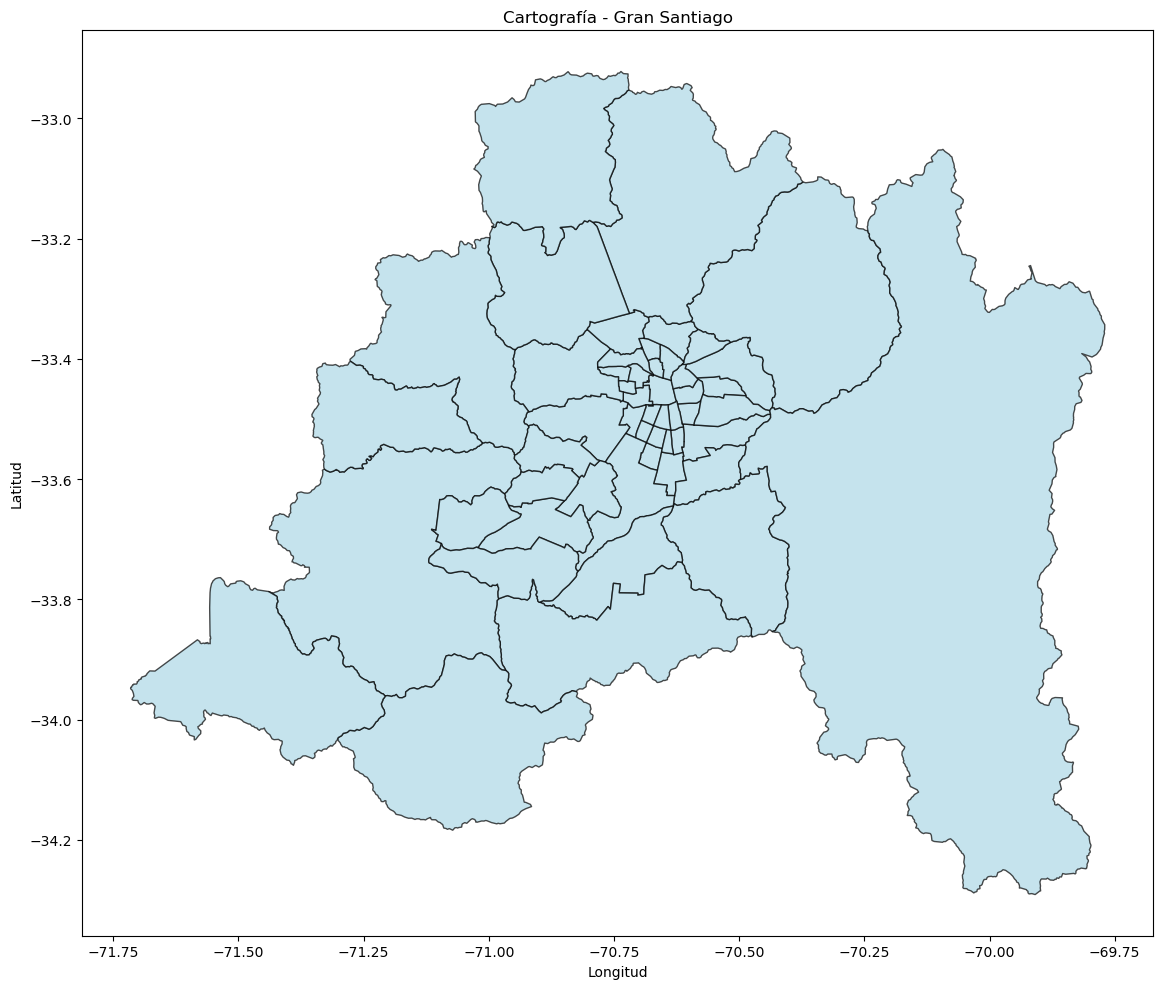

Gran Santiago: 52 polígonos (52 comunas)
Comunas: ['ALHUÉ', 'BUIN', 'CALERA DE TANGO', 'CERRILLOS', 'CERRO NAVIA', 'COLINA', 'CONCHALÍ', 'CURACAVÍ', 'EL BOSQUE', 'EL MONTE', 'ESTACIÓN CENTRAL', 'HUECHURABA', 'INDEPENDENCIA', 'ISLA DE MAIPO', 'LA CISTERNA', 'LA FLORIDA', 'LA GRANJA', 'LA PINTANA', 'LA REINA', 'LAMPA', 'LAS CONDES', 'LO BARNECHEA', 'LO ESPEJO', 'LO PRADO', 'MACUL', 'MAIPÚ', 'MARÍA PINTO', 'MELIPILLA', 'PADRE HURTADO', 'PAINE', 'PEDRO AGUIRRE CERDA', 'PEÑAFLOR', 'PEÑALOLÉN', 'PIRQUE', 'PROVIDENCIA', 'PUDAHUEL', 'PUENTE ALTO', 'QUILICURA', 'QUINTA NORMAL', 'RECOLETA', 'RENCA', 'SAN BERNARDO', 'SAN JOAQUÍN', 'SAN JOSÉ DE MAIPO', 'SAN MIGUEL', 'SAN PEDRO', 'SAN RAMÓN', 'SANTIAGO', 'TALAGANTE', 'TILTIL', 'VITACURA', 'ÑUÑOA']


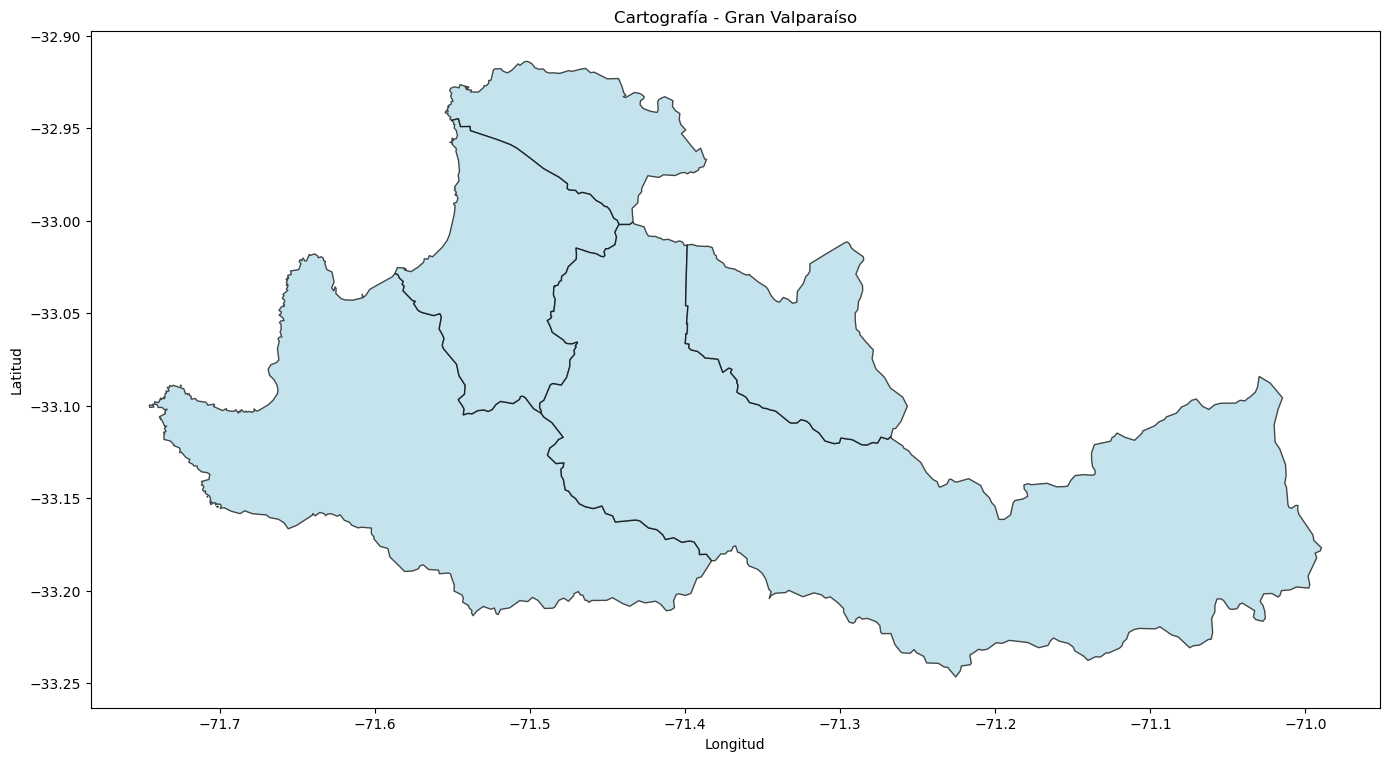

Gran Valparaíso: 5 polígonos (5 comunas)
Comunas: ['CONCÓN', 'QUILPUÉ', 'VALPARAÍSO', 'VILLA ALEMANA', 'VIÑA DEL MAR']


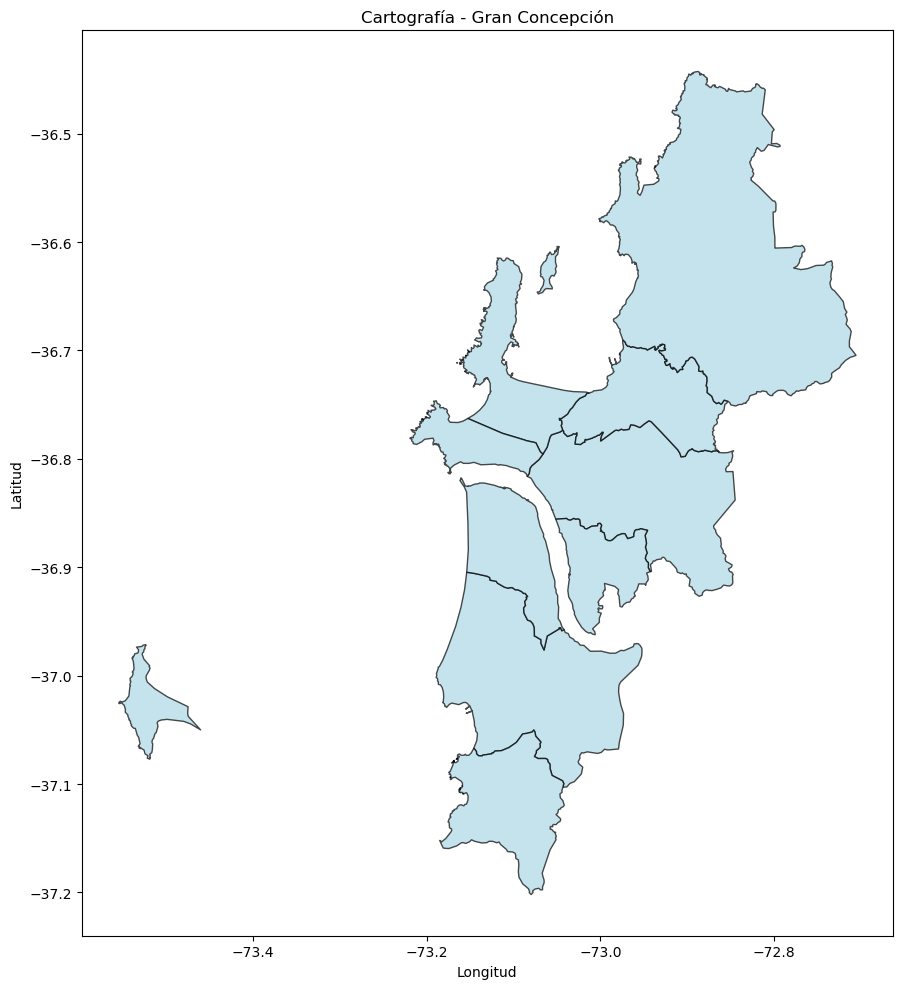

Gran Concepción: 9 polígonos (9 comunas)
Comunas: ['CHIGUAYANTE', 'CONCEPCIÓN', 'CORONEL', 'HUALPÉN', 'LOTA', 'PENCO', 'SAN PEDRO DE LA PAZ', 'TALCAHUANO', 'TOMÉ']


In [13]:
import matplotlib.pyplot as plt

# Procesar y graficar cada caso
for nombre, df_caso in resultados_casos.items():
    if df_caso is None:
        continue
    
    region_code = region_map[nombre]
    
    # Filtrar cartografía por región
    carto_caso = carto[carto['COD_REG'] == str(region_code)].copy()
    
    # Para Gran Valparaíso, filtrar solo las comunas metropolitanas
    if nombre == 'Gran Valparaíso':
        comunas_metropolitanas = ['QUILPUÉ','VILLA ALEMANA','VALPARAÍSO','VIÑA DEL MAR','CONCÓN']
        carto_caso = carto_caso[carto_caso['COMUNA'].isin(comunas_metropolitanas)].copy()
    
        # Remover solo las partes/polígonos que estén fuera del rango continental
        # Ampliar rango para incluir todas las comunas: -74.0 a -70.5
        def filtrar_geometria(geom):
            """Mantiene solo las partes de la geometría dentro del rango continental"""
            if geom.geom_type == 'MultiPolygon':
                polys_filtrados = []
                for poly in geom.geoms:
                    bounds = poly.bounds  # (minx, miny, maxx, maxy)
                    if bounds[0] > -74.0 and bounds[2] < -70.5:  # minx > -74.0 and maxx < -70.5
                        polys_filtrados.append(poly)
                if polys_filtrados:
                    if len(polys_filtrados) == 1:
                        return polys_filtrados[0]
                    else:
                        from shapely.geometry import MultiPolygon
                        return MultiPolygon(polys_filtrados)
                return None
            elif geom.geom_type == 'Polygon':
                bounds = geom.bounds
                if bounds[0] > -74.0 and bounds[2] < -70.5:
                    return geom
                return None
            return geom
        
        # Aplicar filtro a cada geometría
        carto_caso['geometry'] = carto_caso['geometry'].apply(filtrar_geometria)
        # Remover geometrías None
        carto_caso = carto_caso[carto_caso['geometry'].notna()]
    if nombre=='Gran Concepción':
        comunas=['CONCEPCIÓN','SAN PEDRO DE LA PAZ','CHIGUAYANTE','HUALPÉN','TALCAHUANO','PENCO','CORONEL','LOTA','TOMÉ']
        carto_caso = carto_caso[carto_caso['COMUNA'].isin(comunas)].copy()
    # Graficar
    fig, ax = plt.subplots(figsize=(14, 10))
    carto_caso.plot(ax=ax, alpha=0.7, edgecolor='k', facecolor='lightblue')
    plt.title(f'Cartografía - {nombre}')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.tight_layout()
    plt.show()
    
    print(f"{nombre}: {len(carto_caso)} polígonos ({carto_caso['COMUNA'].nunique()} comunas)")
    print(f"Comunas: {sorted(carto_caso['COMUNA'].unique())}")

In [15]:
# Calcular centroides para cada caso
centroides_casos = {}

for nombre, df_caso in resultados_casos.items():
    if df_caso is None:
        continue
    
    # Filtrar cartografía según el caso (mismo criterio que en visualización)
    if nombre == 'Gran Valparaíso':
        region_code = region_map[nombre]
        carto_caso = carto[carto['COD_REG'] == str(region_code)].copy()
        comunas_metropolitanas = ['QUILPUÉ','VILLA ALEMANA','VALPARAÍSO','VIÑA DEL MAR','CONCÓN']
        carto_caso = carto_caso[carto_caso['COMUNA'].isin(comunas_metropolitanas)].copy()
        
        # Aplicar filtro de geometría
        def filtrar_geometria(geom):
            if geom.geom_type == 'MultiPolygon':
                polys_filtrados = []
                for poly in geom.geoms:
                    bounds = poly.bounds
                    if bounds[0] > -74.0 and bounds[2] < -70.5:
                        polys_filtrados.append(poly)
                if polys_filtrados:
                    if len(polys_filtrados) == 1:
                        return polys_filtrados[0]
                    else:
                        from shapely.geometry import MultiPolygon
                        return MultiPolygon(polys_filtrados)
                return None
            elif geom.geom_type == 'Polygon':
                bounds = geom.bounds
                if bounds[0] > -74.0 and bounds[2] < -70.5:
                    return geom
                return None
            return geom
        
        carto_caso['geometry'] = carto_caso['geometry'].apply(filtrar_geometria)
        carto_caso = carto_caso[carto_caso['geometry'].notna()]
    
    elif nombre == 'Gran Concepción':
        region_code = region_map[nombre]
        carto_caso = carto[carto['COD_REG'] == str(region_code)].copy()
        # Filtrar solo las comunas del Gran Concepción metropolitano
        comunas_concepcion = ['CONCEPCIÓN','SAN PEDRO DE LA PAZ','CHIGUAYANTE','HUALPÉN','TALCAHUANO','PENCO','CORONEL','LOTA','TOMÉ']
        carto_caso = carto_caso[carto_caso['COMUNA'].isin(comunas_concepcion)].copy()
    
    else:  # Gran Santiago
        region_code = region_map[nombre]
        carto_caso = carto[carto['COD_REG'] == str(region_code)].copy()
    
    # Calcular centroides
    carto_caso['centroide'] = carto_caso.geometry.centroid
    
    # Extraer coordenadas
    centroides_df = carto_caso[['COMUNA', 'centroide']].copy()
    centroides_df['longitude'] = centroides_df['centroide'].apply(lambda p: p.x)
    centroides_df['latitude'] = centroides_df['centroide'].apply(lambda p: p.y)
    centroides_df = centroides_df[['COMUNA', 'longitude', 'latitude']]
    
    # Agrupar por comuna
    centroides_df = centroides_df.drop_duplicates(subset=['COMUNA']).reset_index(drop=True)
    
    centroides_casos[nombre] = centroides_df
    
    print(f"\n{nombre} - Centroides ({len(centroides_df)} comunas):")
    print(centroides_df.to_string(index=False))

C:\Users\naoca\AppData\Local\Temp\ipykernel_22668\2841875454.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  carto_caso['centroide'] = carto_caso.geometry.centroid
C:\Users\naoca\AppData\Local\Temp\ipykernel_22668\2841875454.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  carto_caso['centroide'] = carto_caso.geometry.centroid
C:\Users\naoca\AppData\Local\Temp\ipykernel_22668\2841875454.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  carto_caso['centroide'] = carto_caso.geometry.centroid



Gran Santiago - Centroides (52 comunas):
             COMUNA  longitude   latitude
           SANTIAGO -70.656669 -33.453294
          CERRILLOS -70.712354 -33.499506
        CERRO NAVIA -70.744058 -33.422224
           CONCHALÍ -70.676557 -33.383409
          EL BOSQUE -70.676166 -33.562749
   ESTACIÓN CENTRAL -70.700781 -33.464037
         HUECHURABA -70.637653 -33.360161
      INDEPENDENCIA -70.665065 -33.414380
        LA CISTERNA -70.663821 -33.530071
         LA FLORIDA -70.539837 -33.528105
          LA GRANJA -70.622501 -33.535620
         LA PINTANA -70.637138 -33.587586
           LA REINA -70.536570 -33.447081
         LAS CONDES -70.500641 -33.421018
       LO BARNECHEA -70.368551 -33.299166
          LO ESPEJO -70.689756 -33.520414
           LO PRADO -70.722945 -33.446736
              MACUL -70.599833 -33.489257
              MAIPÚ -70.809432 -33.506725
              ÑUÑOA -70.598830 -33.457775
PEDRO AGUIRRE CERDA -70.675494 -33.491519
          PEÑALOLÉN -70.525108 -33

C:\Users\naoca\AppData\Local\Temp\ipykernel_22668\2160653994.py:75: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')


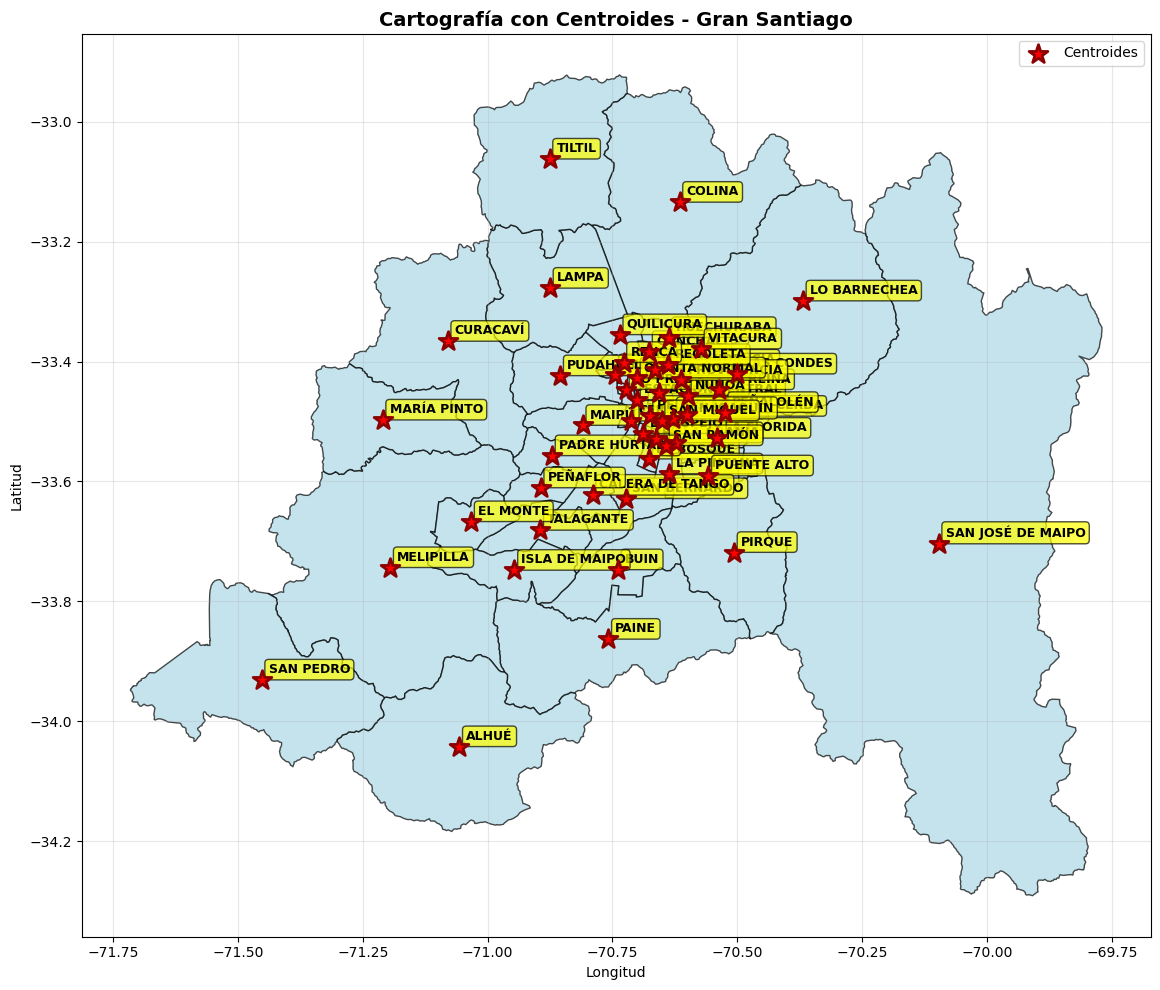


Gran Santiago: 52 polígonos, 52 centroides


C:\Users\naoca\AppData\Local\Temp\ipykernel_22668\2160653994.py:75: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')


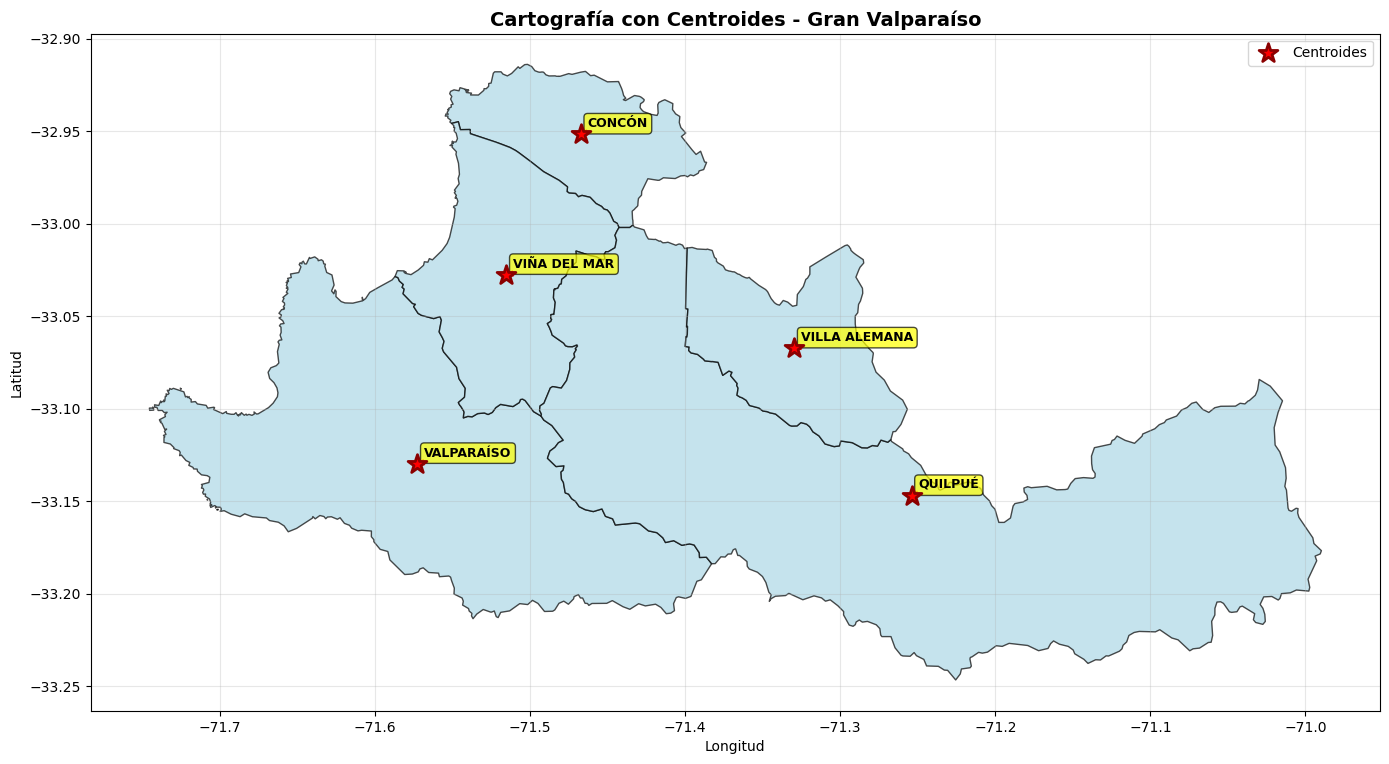


Gran Valparaíso: 5 polígonos, 5 centroides


C:\Users\naoca\AppData\Local\Temp\ipykernel_22668\2160653994.py:75: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right')


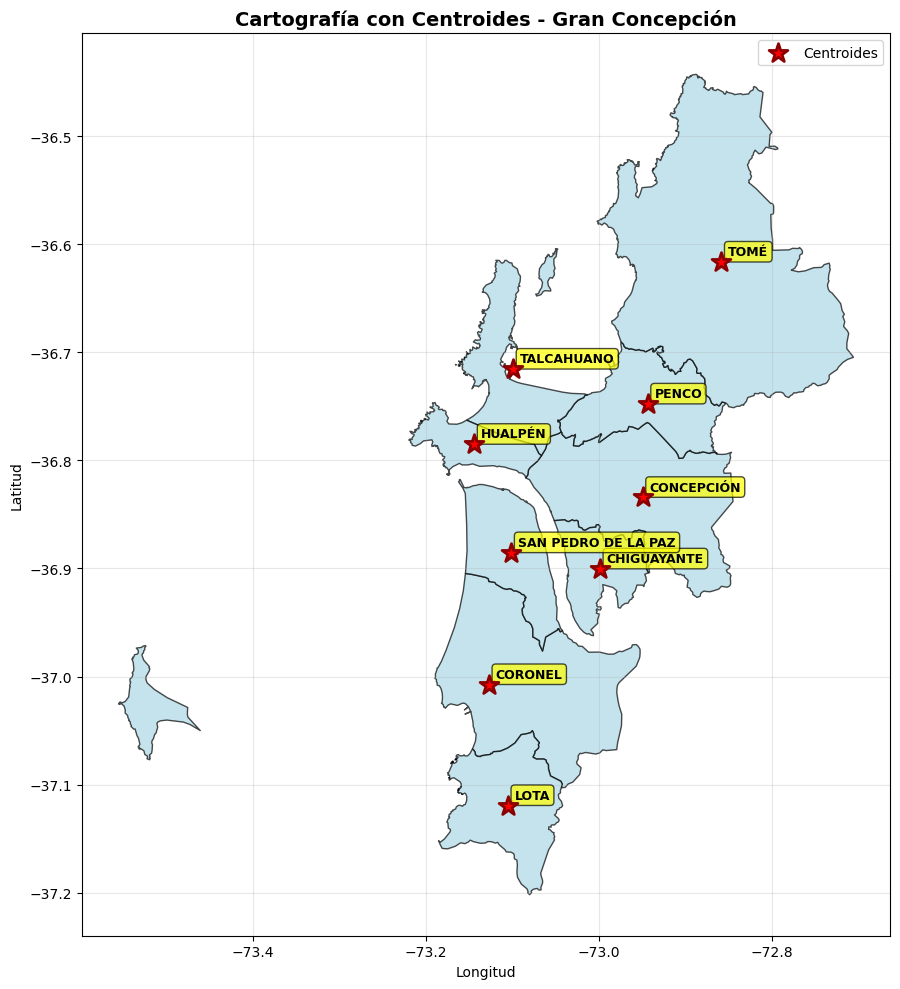


Gran Concepción: 9 polígonos, 9 centroides


In [16]:
# Graficar centroides sobre la cartografía
for nombre, df_caso in resultados_casos.items():
    if df_caso is None:
        continue
    
    # Filtrar cartografía según el caso
    if nombre == 'Gran Valparaíso':
        region_code = region_map[nombre]
        carto_caso = carto[carto['COD_REG'] == str(region_code)].copy()
        comunas_metropolitanas = ['QUILPUÉ','VILLA ALEMANA','VALPARAÍSO','VIÑA DEL MAR','CONCÓN']
        carto_caso = carto_caso[carto_caso['COMUNA'].isin(comunas_metropolitanas)].copy()
        
        # Aplicar filtro de geometría para remover islas
        def filtrar_geometria(geom):
            if geom.geom_type == 'MultiPolygon':
                polys_filtrados = []
                for poly in geom.geoms:
                    bounds = poly.bounds
                    if bounds[0] > -74.0 and bounds[2] < -70.5:
                        polys_filtrados.append(poly)
                if polys_filtrados:
                    if len(polys_filtrados) == 1:
                        return polys_filtrados[0]
                    else:
                        from shapely.geometry import MultiPolygon
                        return MultiPolygon(polys_filtrados)
                return None
            elif geom.geom_type == 'Polygon':
                bounds = geom.bounds
                if bounds[0] > -74.0 and bounds[2] < -70.5:
                    return geom
                return None
            return geom
        
        carto_caso['geometry'] = carto_caso['geometry'].apply(filtrar_geometria)
        carto_caso = carto_caso[carto_caso['geometry'].notna()]
    
    elif nombre == 'Gran Concepción':
        region_code = region_map[nombre]
        carto_caso = carto[carto['COD_REG'] == str(region_code)].copy()
        # Filtrar solo las comunas del Gran Concepción metropolitano
        comunas_concepcion = ['CONCEPCIÓN','SAN PEDRO DE LA PAZ','CHIGUAYANTE','HUALPÉN','TALCAHUANO','PENCO','CORONEL','LOTA','TOMÉ']
        carto_caso = carto_caso[carto_caso['COMUNA'].isin(comunas_concepcion)].copy()
    
    else:  # Gran Santiago
        region_code = region_map[nombre]
        carto_caso = carto[carto['COD_REG'] == str(region_code)].copy()
    
    # Obtener centroides para este caso
    centroides_df = centroides_casos[nombre]
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Graficar cartografía
    carto_caso.plot(ax=ax, alpha=0.7, edgecolor='k', facecolor='lightblue', label='Comunas')
    
    # Graficar centroides como puntos rojos
    ax.scatter(centroides_df['longitude'], centroides_df['latitude'], 
               color='red', s=200, marker='*', edgecolor='darkred', linewidth=2, 
               label='Centroides', zorder=5)
    
    # Añadir etiquetas a los centroides (nombres de comunas)
    for idx, row in centroides_df.iterrows():
        ax.annotate(row['COMUNA'], 
                   xy=(row['longitude'], row['latitude']),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red'))
    
    ax.set_title(f'Cartografía con Centroides - {nombre}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{nombre}: {len(carto_caso)} polígonos, {len(centroides_df)} centroides")


In [17]:
df.head(5)

,id_vivienda,id_hogar,id_persona,region,provincia,comuna,comuna_bajo_umbral,area,tipo_operativo,sexo,...,p46c_hijos_nac,p47a_tot_hijs_sobrev,p47b_hijas_sobrev,p47c_hijos_sobrev,p48_anio_nac_uh,p48_mes_nac_uh,div_genero,p45_medio_transporte_desc,comuna_map,lugar_trabajo
0,1.0,1.0,1.0,5.0,58.0,5802.0,2.0,1.0,2.0,2.0,...,1.0,3.0,2.0,1.0,1978.0,7.0,2.0,NaN,Limache,NaN
1,1.0,1.0,2.0,5.0,58.0,5802.0,2.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Transporte público,Limache,Varias comunas o países
2,1.0,1.0,3.0,5.0,58.0,5802.0,2.0,1.0,2.0,2.0,...,0.0,1.0,1.0,0.0,2015.0,9.0,2.0,Caminando,Limache,Limache
3,1.0,1.0,4.0,5.0,58.0,5802.0,2.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Limache,NaN
4,2.0,1.0,1.0,4.0,43.0,4303.0,2.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-66.0,NaN,Monte Patria,NaN


In [23]:
df=df[['region','provincia','area','sexo','edad_quinquenal','comuna_map','lugar_trabajo','p45_medio_transporte_desc','discapacidad','p27_nacionalidad_esp']]

In [ ]:
# Calcular distancia entre dos puntos (lat/lon en grados) en km
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calcula la distancia entre dos puntos en la tierra (en km)
    usando la fórmula de Haversine
    """
    # convertir grados decimales a radianes
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # fórmula de haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # radio de la tierra en km
    return c * r

# Procesar datos para calcular distancias
datos_distancia = []

for nombre in ['Gran Santiago', 'Gran Valparaíso', 'Gran Concepción']:
    print(f"\nProcesando {nombre}...")
    df_caso = resultados_casos[nombre]
    
    if df_caso is None:
        continue
    
    # Obtener datos del dataframe de Dask
    df_caso_computed = df_caso[['comuna_map', 'lugar_trabajo', 'p45_medio_transporte_desc']].compute()
    
    # Contar registros
    total_registros = len(df_caso_computed)
    print(f"Total registros en {nombre}: {total_registros}")
    
    for idx, row in df_caso_computed.iterrows():
        comuna_residencia = row['comuna_map']
        comuna_trabajo = row['lugar_trabajo']
        transporte = row['p45_medio_transporte_desc']
        
        # Buscar coordenadas
        if (comuna_residencia in comunas_dict_all and 
            comuna_trabajo in comunas_dict_all and 
            pd.notna(transporte)):
            
            coords_res = comunas_dict_all[comuna_residencia]
            coords_trab = comunas_dict_all[comuna_trabajo]
            
            distancia = haversine(
                coords_res['lon'], coords_res['lat'],
                coords_trab['lon'], coords_trab['lat']
            )
            
            datos_distancia.append({
                'region': nombre,
                'comuna_residencia': comuna_residencia,
                'comuna_trabajo': comuna_trabajo,
                'transporte': transporte,
                'distancia_km': distancia
            })
    
    if len(datos_distancia) % 1000 == 0:
        print(f"Registros procesados: {len(datos_distancia)}")

print(f"\nTotal de registros con distancia calculada: {len(datos_distancia)}")

# Crear DataFrame con resultados
df_distancia = pd.DataFrame(datos_distancia)
print("\nPrimeros registros:")
print(df_distancia.head(10))
print("\nEstadísticas de distancia por transporte:")
print(df_distancia.groupby('transporte')['distancia_km'].describe())


Procesando Gran Santiago...


In [ ]:
# Visualización: Distancia promedio por modo de transporte
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular estadísticas por transporte y región
dist_por_transporte = df_distancia.groupby(['transporte', 'region'])['distancia_km'].agg(['mean', 'median', 'std', 'count']).reset_index()
print("Distancia promedio por transporte y región:")
print(dist_por_transporte)

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gráfico de barras: Distancia promedio por transporte
ax1 = axes[0, 0]
dist_por_trans_general = df_distancia.groupby('transporte')['distancia_km'].mean().sort_values(ascending=False)
colors = plt.cm.viridis(range(len(dist_por_trans_general)))
dist_por_trans_general.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Distancia Promedio (km)')
ax1.set_title('Distancia Promedio por Modo de Transporte (Todas las Regiones)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Gráfico de cajas: Distribución por transporte
ax2 = axes[0, 1]
df_distancia.boxplot(column='distancia_km', by='transporte', ax=ax2)
ax2.set_xlabel('Modo de Transporte')
ax2.set_ylabel('Distancia (km)')
ax2.set_title('Distribución de Distancias por Modo de Transporte', fontsize=12, fontweight='bold')
plt.sca(ax2)
plt.xticks(rotation=45, ha='right', fontsize=9)

# 3. Gráfico de barras agrupadas: Por región y transporte
ax3 = axes[1, 0]
pivot_data = dist_por_transporte.pivot(index='transporte', columns='region', values='mean')
pivot_data.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_xlabel('Modo de Transporte')
ax3.set_ylabel('Distancia Promedio (km)')
ax3.set_title('Distancia Promedio por Transporte y Región', fontsize=12, fontweight='bold')
ax3.legend(title='Región', loc='best')
plt.sca(ax3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Tabla resumen
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

# Preparar datos para tabla
tabla_data = []
for transporte in dist_por_transporte['transporte'].unique():
    fila_trans = dist_por_transporte[dist_por_transporte['transporte'] == transporte]
    dist_prom = fila_trans['mean'].mean()
    count_total = fila_trans['count'].sum()
    tabla_data.append([
        transporte,
        f"{dist_prom:.2f}",
        f"{count_total:.0f}"
    ])

tabla = ax4.table(cellText=tabla_data,
                  colLabels=['Transporte', 'Dist. Prom (km)', 'Cantidad'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
tabla.auto_set_font_size(False)
tabla.set_fontsize(9)
tabla.scale(1, 2)

# Colorear encabezado
for i in range(3):
    tabla[(0, i)].set_facecolor('#40466e')
    tabla[(0, i)].set_text_props(weight='bold', color='white')

ax4.set_title('Resumen de Distancias por Transporte', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n✓ Visualización completada")